# Lab 10 Dynamical Friction

Starting from the Homework 7 Solutions, add Dynamical Friction to better match the simulation data. 



In [1]:
# import necessary modules
# numpy provides powerful multi-dimensional 
#arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
# astropy provides unit system and constants 
#for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex
%matplotlib inline

# import the CenterOfMass to determine the COM pos/vel of M33
from CenterOfMass2 import CenterOfMass
# import the GalaxyMass to determine the 
#mass of M31 for each component
from GalaxyMass import ComponentMass

# M33AnalyticOrbit - Version 2

1. Add a new variable to the initializer for the class,  `self.M33halo`,  that defines M33's halo mass.

2. Add a new varaible to the initialization of the class, `self.Vc`, the circular speed at large radii from M31. Let's assume this is flat at $V_c$ = 200 km/s in the M31 halo outskirts.  or 230 from Homework 5

3. Add a function called `DynamicalFriction` that takes as inputs (Msat,r,v), and computes the acceleration, assuming an isothermal sphere profile for the dark matter halo of M31.

$ {\bf a} =  -0.428 \frac{GM_{\rm sat} \rm{ln}(\Lambda)}{r^2} \frac{\bf v}{v} $ 

Where the ${\rm ln}(\Lambda)$ is the Coulomb logairthm 

$\Lambda = \frac{bmax}{bmin} $

$bmax$ = the current separation between M31 and M33 and 

$bmin = \frac{GM_{sat}}{V_c^2}$

4. Include this function in M33Accel.  Note that it will require a new input, v (velocity vector). This must be accounted for also when M33Accel is called in LeapFrog 

5. If the orbit doesn't match well. Add a fudge factor (`self.fudge`) that is some fraction of 1 to decrease the strength of the dynamical friction term. 

6. What other reasons might there be for why the orbits don't match?

In [39]:
class M33AnalyticOrbit:
    '''Class that integrates the orbit of 
    M33 based on the analytic form of M31's potential'''
    
    
    def __init__(self, filename):
        '''
        This class uses leapfrog integration 
        to calculate the orbit of M33 around M31,
        using the analytic potentials for each 
        of M31's components.

        PARAMETERS
        ----------
        filename : `str`
            Name of the file in which to store the orbit
        '''    
        
        # get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        # store the output file name
        self.filename = filename
        
        # get the COM position and velocity of each galaxy using disk particles
        
        # COM object 
        com_M31 = CenterOfMass('M31_000.txt', 2) # COM object for M31
        com_M33 = CenterOfMass('M33_000.txt', 2) # COM object for M33
        # COM Pos and Velocity for M31
        com_p_M31 = com_M31.COM_P(volDec=2, delta=0.1)
        com_v_M31 = com_M31.COM_V(com_p_M31[0], com_p_M31[1], com_p_M31[2])
        # COM Pos and Velocity for for M33
        com_p_M33 = com_M33.COM_P(volDec=4, delta=0.1)
        com_v_M33 = com_M33.COM_V(com_p_M33[0], com_p_M33[1], com_p_M33[2])

        # set up initial conditions (M33 pos and velocity relative to M31)
        self.r0 = (com_p_M33 - com_p_M31).value # separation vector in kpc
        self.v0 = (com_v_M33 - com_v_M31).value # relative velocity in km/s
             
            
            
        # set up M31 potential parameters
        
        # M31 disk
        self.rdisk = 5.0 # disk scale length in kpc
        self.Mdisk = ComponentMass("M31_000.txt", 2)*1e12 # disk mass in Msun
        
        # M31 bulge
        self.rbulge = 1.0 # bulge scale length in kpc
        self.Mbulge = ComponentMass("M31_000.txt", 3)*1e12 # bulge mass in Msun
        
        # M31 Halo
        self.rhalo = 61.58 # Halo Scale Length: use the Hernquist scale length, computed in HW5
        self.Mhalo = ComponentMass("M31_000.txt", 1)*1e12  # halo mass in Msun
     
        
        ### ADD M33 HALO MASS HERE #### 
        self.M33halo = ComponentMass("M33_000.txt", 1)*1e12 # halo mass in Msun
    
        ### ADD M31 CIRCULAR SPEED HERE ### 
        self.Vc = 180.0 # circular speed in km/s (hmw 5)

        
        ### Fudge factor ## 
        self.fudge = 0.68 # fudge factor for the Hernquist potential

    
    
    
    def HernquistAccel(self, M, r_a, r):
        '''
        This method computes the 3-D acceleration due to a Hernquist potential.

        PARAMETERS
        ----------
        M : `float`
            Total mass responsible for the potential in Msun
        r_a : `float`
            Scale length in kpc
        r : `np.ndarray`
            Position vector to find the acceleration at

        RETURNS
        -------
        a : `np.ndarray`
            Acceleration vector in kpc/Gyr^2
        '''

        # follow the formula in the HW instructions
        r_mag = np.sqrt(np.sum(r**2))
        
        # Acceleration for a Hernquist Potential
        # Terms that are constant per component
        M_const = self.G * M / (r_mag * (r_a + r_mag)**2) 
        a = -M_const*r # acceleration per component
        
        return a
    
    
    
    def MiyamotoNagaiAccel(self, M, rd, r):
        '''
        This method computes the 3-D acceleration due to a Miyamoto-Nagai disk.

        PARAMETERS
        ----------
        M : `float`
            Disk mass responsible for the potential in Msun
        r_d : `float`
            Disk scale length in kpc
        r : `np.ndarray`
            Position vector to find the acceleration (kpc)

        RETURNS
        -------
        a : `np.ndarray`
            Acceleration vector in kpc/Gyr^2
        '''
        # follow the formula for a Miyamoto-Nagai Disk from the HW instructions
       
        # Intermediate Terms
        R2 = np.sum(r[:2]**2)
        zd = rd / 5.0
        B = rd + np.sqrt(r[2]**2 + zd**2)
        
        # constant term in all three components
        M_const = self.G * M / (R2 + B**2)**1.5
        
        # vector of additional terms
        # the np.array allows for a different value for the z component of the acceleration
        vec = np.array([1., 1., B/np.sqrt(r[2]**2 + zd**2)])
        
        # Acceleration
        a = -M_const*vec*r
       
        return a
     
    
    ########### ADD Dynamical Friction Method Here ##################
    def DynamicalFriction(self, Msat, Vc, r, v):
        """This method computes tbe dynamical friction acceleration on M33 
        due to its motion through dark matter halo of M31.
        
        PARAMETERS
        ----------
        Msat : `float`
            Mass of satellite in Msun
        Vc : `float`
            Max Circular velocity of the host dark matter halo in km/s
        r : `np.ndarray`
            Position vector of satellite relative to the host in kpc
        v : `np.ndarray`
            Velocity vector of the satellite relative to the host in km/s

        RETURNS
        -------
        DF : `np.ndarray`
            deceleration vector owing to dynamical friction
        """
        # magnitude of the relative velocity and position vectors
        r_mag = np.sqrt(np.sum(r**2))
        v_mag = np.sqrt(np.sum(v**2))
        
        # For the coulomb logarithm
        # bmax: current separation between M33 and M31
        bmax = r_mag 

        # bmin: radius of a strong interaction
        # G Msat/ Vc^2
        bmin = self.G * Msat / Vc**2

        # Coulomb logarithm
        Coulomb = np.log(bmax/bmin)

        #DYnamical Friction

        DF = -0.428 * self.G * Msat * Coulomb/r_mag**2*v/v_mag*self.fudge

        return DF

     ##### ADD v to M31Accel input #### 
    def M31Accel(self, r, v):
        '''
        This method computes the 3-D acceleration due to M31.

        PARAMETERS
        ----------
        r : `np.ndarray`
            Position vector to find the acceleration at

        v : `np.ndarray`
            Velocity vector of M33 relative to M31 in km/s

        RETURNS
        -------
        a : `np.ndarray`
            Acceleration vector in kpc/Gyr^2
        '''
        
        # Compute the acceleration from each galaxy component
        ahalo = self.HernquistAccel(self.Mhalo, self.rhalo, r) 
        abulge = self.HernquistAccel(self.Mbulge, self.rbulge, r) 
        adisk = self.MiyamotoNagaiAccel(self.Mdisk, self.rdisk, r)
    
        ###### ADD DYNAMICAL FRICTION HERE and include in "a"
        aDF = self.DynamicalFriction(self.M33halo, self.Vc, r, v)

        a = ahalo+abulge+adisk+aDF
        
        return a # return the total acceleration
    
    
    def LeapFrog(self, dt, r, v):
        '''This method is a leapfrog integrator for evolving the position
        and velocity of M33 in time. One call produces one timestep.

        PARAMETERS
        ----------
        dt : `float`
            timestep in Gyr
        r : `np.ndarray`
            position vector at the start of the timestep in kpc
        v : `np.ndarray`
            velocity vector at the start of the timestep in km/s

        RETURNS
        -------
        rnext : `np.ndarray`
            position vector at the end of the timestep in kpc
        vnext : `np.ndarray`
            velocity vector at the end of the timestep in km/s
        '''
        
        # predict the position at the next half timestep
        r_half = r + v * (dt / 2.0)
        
        # compute the velocity at the next timestep
        ##### ADD v as input to M31Accel ### 
        vnext = v + self.M31Accel(r_half, v) * dt
        
        # compute the position at the next timestep
        rnext = r + (vnext+v) * dt / 2.0
        
        return rnext, vnext
    
    
    
    def OrbitIntegration(self, t0, dt, tmax):
        '''This method integrates the orbit of M33 and stores the position
            and velocity of M33 (in the COM frame of M31) at each timestep in a file. 

        PARAMETERS
        ----------
        t0 : `float`
            Start time in Gyr
        dt : `float`
            Timestep in Gyr
        tmax : `float`
            End time in Gyr
        ''' 
        
        # find out how many timesteps we have
        N_steps = int((tmax - t0)/dt)+1 # add 1 to account for the integer rounding
        
        # set up orbit array, two more rows than t/dt allow for storing the ICs
        # and account for the rounding of the number of time intervals to an integer
        orbit = np.zeros([N_steps+1, 7]) # first row will be for the ICs
        #orbit = np.zeros([int(tmax/dt)+2, 7])
        
        
        
        # initialize the time , position, velocity
        t = t0 # initial time
        r = self.r0 # initial p
        v = self.v0 # initial v
        
        # and store the ICs for M33 in the first row of the orbit file
        # Initial time, initial position relative to M31, initial velocity relative to M31
        orbit[0] = t0, *tuple(r), *tuple(v)
        
        
        i = 1 # step counter, starts at 1 since the 0th timestep is the ICs above.
        
        # start the integration
        while (t < tmax):
            # update time
            t += dt
            
            # update positions and velocities with the leapfrog function
            r, v = self.LeapFrog(dt, r, v)
            
            # store system state
            orbit[i] = t, *tuple(r), *tuple(v)
            
            # print progress and increment step counter
            print(f'Finished step {i} of {N_steps}') 
            
            i += 1 # update counter
        
        # write the data to a file
        np.savetxt(self.filename, orbit, fmt = "%11.3f"*7, comments='#', 
                   header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                   .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))
        

In [40]:
# ------------------ FUNCTIONS -------------------# 

# Set the format for reading in the orbit data files   
orbit_type = np.dtype([('t', 'f8'), ('r', 'f8', 3), ('v', 'f8', 3)])


def relative_mag(orbit1, orbit2): 
    """ Function to compute the relative separation and velocity using input orbit files for two galaxies, 
    where the orbit files have `orbit_type` formatting: np.dtype([('t', 'f8'), ('r', 'f8', 3), ('v', 'f8', 3)])

    PARAMETERS
    ----------
    orbit1 : `np.ndarray' 
        first vector, assumed 'orbit_type' formatting
    orbit2 : 'np.ndarray'
        second vector, assumed 'orbit_type' formatting
    RETURNS
    -------
    rel_pos : `float or np.ndarray`
            |pos1 - pos2|
    rel_vel :`float or np.ndarray`
            |vel1 - vel2|
    """
    
    rel_pos = np.sqrt(np.sum((orbit1['r'] - orbit2['r'])**2, axis=1))
    rel_vel = np.sqrt(np.sum((orbit1['v'] - orbit2['v'])**2, axis=1))
    
    return rel_pos,rel_vel
                  
                  
def vector_mag(orbit):
    """ Function to compute the magnitude of the separation and velocity using an input orbit file, 
    where the orbit files have `orbit_type` formatting: np.dtype([('t', 'f8'), ('r', 'f8', 3), ('v', 'f8', 3)])

    PARAMETERS
    ----------
    orbit : `np.ndarray' 
        vector, assumed 'orbit_type' formatting
        
    RETURNS
    --------
    pos : `float or np.ndarray`
         magnitude of the position
    vel : `float or np.ndarray`
         magnitude of the position  
    
    """              
    pos = np.sqrt(np.sum(orbit['r']**2, axis=1)) 
    vel = np.sqrt(np.sum(orbit['v']**2, axis=1))
                      
    return pos, vel

In [41]:
# ------------------- MAIN ---------------------- #


# make instance of the orbit integrator class
M33 = M33AnalyticOrbit("M33AnalyticOrbit_withDF.txt")

# Compute the orbit
M33.OrbitIntegration(0, 0.001, 10.)

Finished step 1 of 10001
Finished step 2 of 10001
Finished step 3 of 10001
Finished step 4 of 10001
Finished step 5 of 10001
Finished step 6 of 10001
Finished step 7 of 10001
Finished step 8 of 10001
Finished step 9 of 10001
Finished step 10 of 10001
Finished step 11 of 10001
Finished step 12 of 10001
Finished step 13 of 10001
Finished step 14 of 10001
Finished step 15 of 10001
Finished step 16 of 10001
Finished step 17 of 10001
Finished step 18 of 10001
Finished step 19 of 10001
Finished step 20 of 10001
Finished step 21 of 10001
Finished step 22 of 10001
Finished step 23 of 10001
Finished step 24 of 10001
Finished step 25 of 10001
Finished step 26 of 10001
Finished step 27 of 10001
Finished step 28 of 10001
Finished step 29 of 10001
Finished step 30 of 10001
Finished step 31 of 10001
Finished step 32 of 10001
Finished step 33 of 10001
Finished step 34 of 10001
Finished step 35 of 10001
Finished step 36 of 10001
Finished step 37 of 10001
Finished step 38 of 10001
Finished step 39 of 1

In [42]:
# With DF 

# Read in Orbit of M33 relative to M31 that we computed using LeapFrog 
M33Orbit = np.loadtxt("M33AnalyticOrbit_withDF.txt", dtype=orbit_type)

#Determine the magnitude of the position and velocities of 
# the galaxies at each point in the orbit
M31_M33_R, M31_M33_V = vector_mag(M33Orbit)


In [43]:
# No DF 

# Read in Orbit of M33 relative to M31 Old, from Homework 7
M33Orbit_Hmwk7 = np.loadtxt("M33AnalyticOrbit_Hmwk7.txt", dtype=orbit_type)

#Determine the magnitude of the position and velocities of 
# of MW and M31 : Homework 7 
M31_M33_R_Hmwk7, M31_M33_V_Hmwk7 = vector_mag(M33Orbit_Hmwk7)



In [44]:
# Actual Simulation

# Read in simulation Orbit from Homework 6
M33SimOrbit = np.genfromtxt('Orbit_M33.txt', dtype = orbit_type)
M31SimOrbit = np.genfromtxt('Orbit_M31.txt', dtype = orbit_type)

#Determine the magnitude of the position and velocities of 
# the galaxies at each point in the orbit
M31_M33_SimR, M31_M33_SimV = relative_mag(M31SimOrbit, M33SimOrbit)

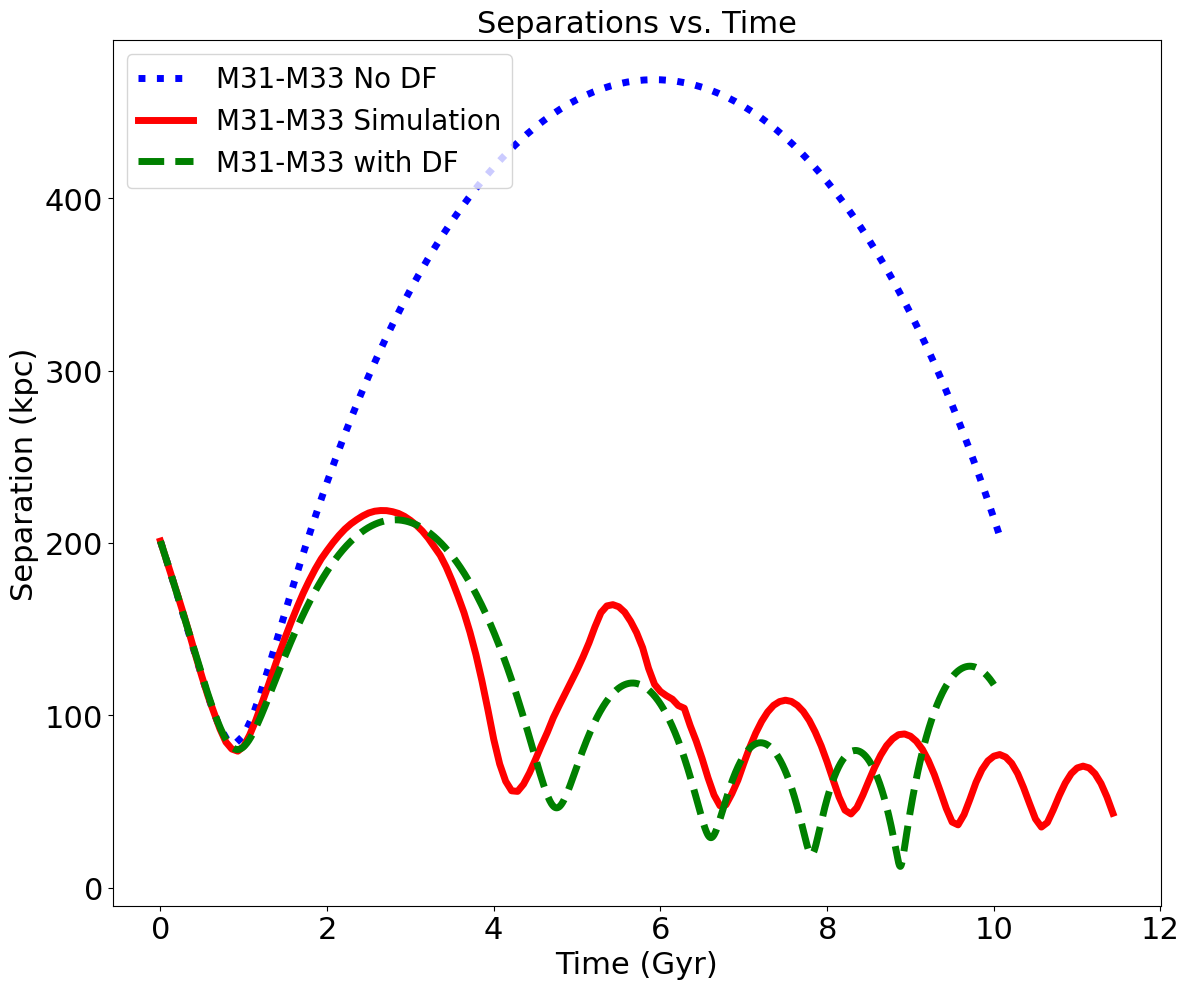

In [45]:
# Plot the orbital separations of the galaxies 
#################################

fig, ax= plt.subplots(figsize=(12, 10))

# Plot the analytical separation of M31 and M33 from Homework 7
ax.plot(M33Orbit_Hmwk7['t'], M31_M33_R_Hmwk7, 'b', lw=5, linestyle=":", label='M31-M33 No DF')

# Plot the simulated separation of M31 and M33
ax.plot(M33SimOrbit['t'], M31_M33_SimR, 'r', lw=5, label='M31-M33 Simulation')

#### Plot the newly computed orbit with DF
ax.plot(M33Orbit['t'], M31_M33_R, 'g',ls = "--", lw=5, label='M31-M33 with DF')


# Add axis labels
ax.set_xlabel('Time (Gyr)', fontsize=22)
ax.set_ylabel('Separation (kpc)', fontsize=22)
ax.set_title("Separations vs. Time", fontsize=22)

#adjust tick label font size
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

# add a legend with some customizations.
legend = ax.legend(loc='upper left',fontsize=20)

# tight layout
fig.tight_layout()

# Save to a file
fig.savefig('orbit_M33_R_withDF.png')

In [ ]:
# Plot the orbital velocities of the galaxies 
#################################

fig, ax= plt.subplots(figsize=(12, 10))

# Plot the analytical velocities of M31 and M33
ax.plot(M33Orbit_Hmwk7['t'], M31_M33_V_Hmwk7, 'b', lw=5, label='M31-M33 No DF')

# Plot the simulated velocities of M31 and M33
ax.plot(M33SimOrbit['t'], M31_M33_SimV, 'r', lw=5, label='M31-M33 Simulation')

###### Plot the new orbit with DF 


# Add axis labels
ax.set_xlabel('Time (Gyr)', fontsize=22)
ax.set_ylabel('Velocity (km/s)', fontsize=22)
ax.set_title("Velocities vs. Time", fontsize=22)

#adjust tick label font size
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

# add a legend with some customizations.
legend = ax.legend(loc='upper left',fontsize=20)

# tight layout
fig.tight_layout()

# Save to a file
fig.savefig('orbit_M33_V_withDF.png')

# 6. What other reasons might there be for why the orbits don't match?